## Evaluation Notebook

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from dataset.dataloader import get_data_loaders
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import pickle as pkl
import torch.nn as nn
import torch.nn.functional as F
from models import DeepCNN

In [ ]:
path = '/projects/dsci410_510/ballpark/'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Read in loss data and the model from train.py

In [ ]:
loss_df = pd.read_csv(path+'loss.csv', low_memory=False)

In [ ]:
model = DeepCNN().to(device)
model.load_state_dict(torch.load(path+'model_weights.pth', weights_only=True))

<All keys matched successfully>

Create loss and accuracy plots

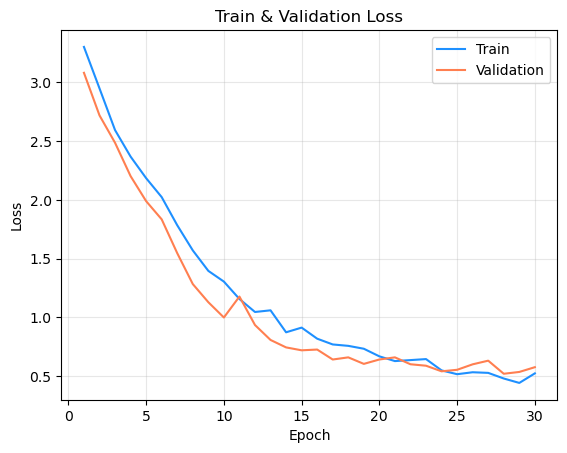

In [39]:
sns.lineplot(data=loss_df, x='epoch', y='train_loss', label="Train", color='dodgerblue')
sns.lineplot(data=loss_df, x='epoch', y='test_loss', label="Validation", color='coral')
plt.legend()
plt.title("Train & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.savefig("loss.png")

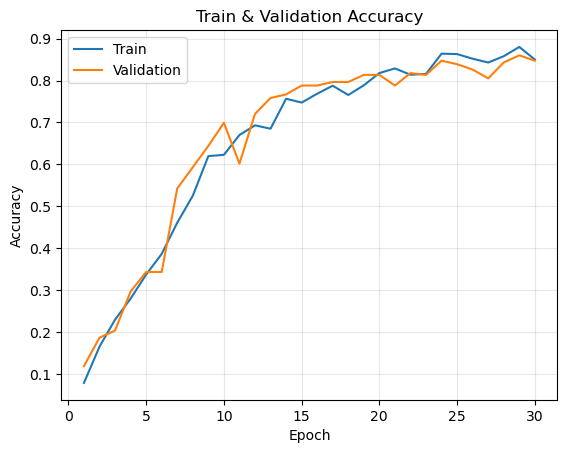

In [40]:
sns.lineplot(data=loss_df, x='epoch', y='train_accuracy', label="Train")
sns.lineplot(data=loss_df, x='epoch', y='test_accuracy', label="Validation")
plt.legend()
plt.title("Train & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)
plt.savefig("accuracy.png")

In [7]:
lookup_dict = {
    0: 'americanfamilyfield-mil', 1: 'angelstadium-laa', 2: 'buschstadium-stl', 3: 'camdenyards-bal', 4: 'chasefield-ari', 5: 'citifield-nym',
    6: 'citizensbankpark-phi', 7: 'comericapark-det', 8: 'coorsfield-col', 9: 'daikinpark-hou', 10: 'dodgerstadium-lad', 11: 'fenwaypark-bos',
    12: 'globelifefield-tex', 13: 'greatamericanballpark-cin', 14: 'kauffmanstadium-kcr', 15: 'loandepotpark-mia', 16: 'nationalspark-was', 
    17: 'oaklandcoliseum-oak', 18: 'oraclepark-sfg', 19: 'petcopark-sdp',20: 'pncpark-pit',21: 'progressivefield-cle',22: 'ratefield-cws',
    23: 'rogerscenter-tor',24: 'targetfield-min',25: 'tmobilepark-sea',26: 'tropicanafield-tbr',27: 'truistpark-atl',28: 'wrigleyfield-chc',29: 'yankeestadium-nyy'
}

In [8]:
train_loader, test_loader, val_loader = get_data_loaders(batch_size=64)

In [9]:
with torch.no_grad():
    model.eval()
    prediction,truth,imgs=zip(*[(torch.softmax(model(x.to(device)),axis=1),y,x) for x,y in test_loader])

prediction=torch.cat(prediction,dim=0).cpu().numpy()
truth=torch.cat(truth,dim=0).cpu().numpy()
imgs=torch.cat(imgs,dim=0).cpu().numpy()
predicted_labels=np.argmax(prediction,axis=1)

In [33]:
test_accuracy = np.round(np.mean(predicted_labels == truth) * 100, 2)
train_accuracy = np.round(loss_df[loss_df['epoch'] == 30]['train_accuracy'].iloc[0] * 100, 2)
val_accuracy = np.round(loss_df[loss_df['epoch'] == 30]['test_accuracy'].iloc[0] * 100, 2)

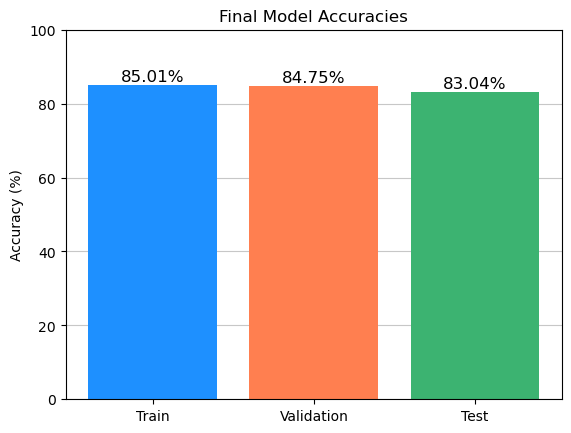

In [42]:
labels = ['Train', 'Validation', 'Test']
accuracies = [train_accuracy, val_accuracy, test_accuracy]

plt.bar(labels, accuracies, color=['dodgerblue', 'coral', 'mediumseagreen'], zorder=2)

plt.title("Final Model Accuracies")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100) 
plt.grid(axis='y', linestyle='-', alpha=0.7, zorder=1)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=12)

plt.savefig("final_accuracies.png")

Examine the worst predictions by the model on the test set.

The first example, of Fenway Park, is a mislabel!

----------------- 155 -----------------
Predicted Probability 1.00 Class 11 fenwaypark-bos
True Class 16 nationalspark-was
(3, 180, 320)


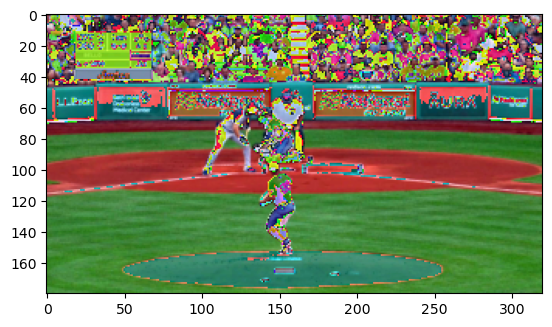

----------------- 276 -----------------
Predicted Probability 0.93 Class 6 citizensbankpark-phi
True Class 29 yankeestadium-nyy
(3, 180, 320)


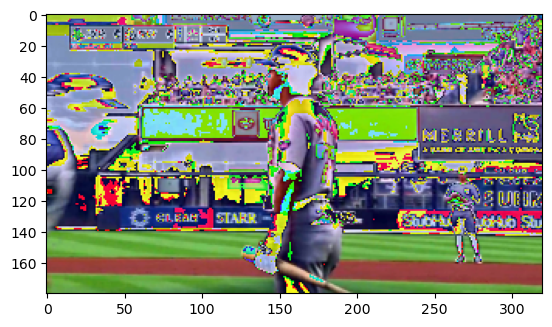

----------------- 71 -----------------
Predicted Probability 0.80 Class 0 americanfamilyfield-mil
True Class 7 comericapark-det
(3, 180, 320)


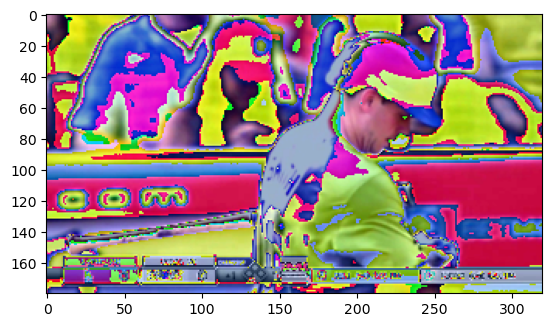

----------------- 182 -----------------
Predicted Probability 0.61 Class 29 yankeestadium-nyy
True Class 18 oraclepark-sfg
(3, 180, 320)


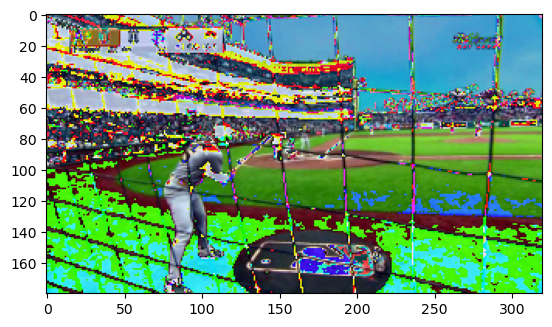

----------------- 248 -----------------
Predicted Probability 0.61 Class 29 yankeestadium-nyy
True Class 25 tmobilepark-sea
(3, 180, 320)


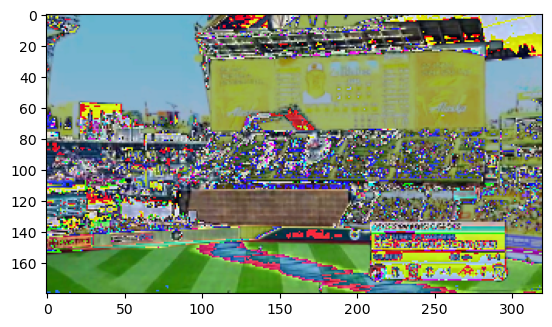

----------------- 267 -----------------
Predicted Probability 0.57 Class 14 kauffmanstadium-kcr
True Class 27 truistpark-atl
(3, 180, 320)


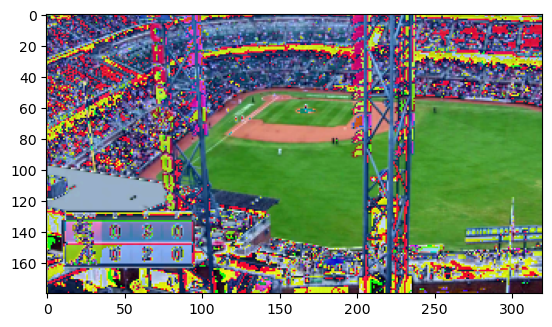

----------------- 166 -----------------
Predicted Probability 0.56 Class 10 dodgerstadium-lad
True Class 17 oaklandcoliseum-oak
(3, 180, 320)


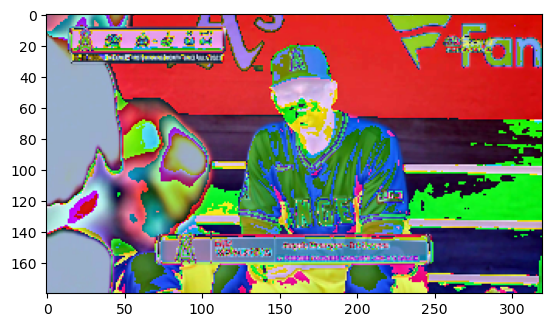

----------------- 95 -----------------
Predicted Probability 0.54 Class 13 greatamericanballpark-cin
True Class 9 daikinpark-hou
(3, 180, 320)


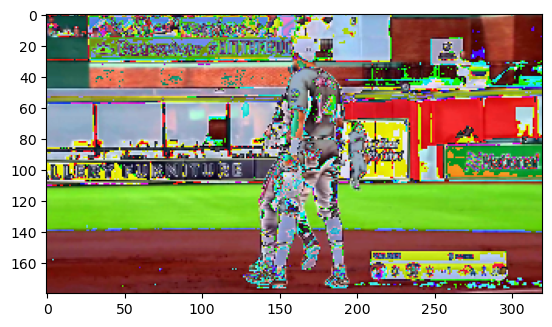

----------------- 116 -----------------
Predicted Probability 0.51 Class 3 camdenyards-bal
True Class 11 fenwaypark-bos
(3, 180, 320)


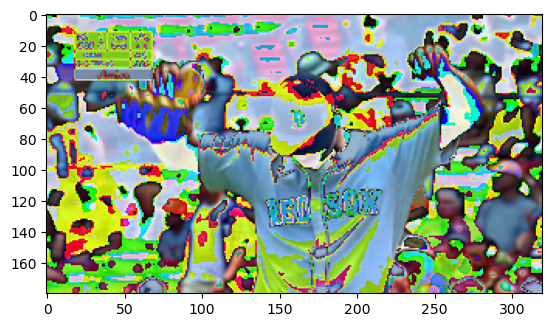

----------------- 18 -----------------
Predicted Probability 0.51 Class 21 progressivefield-cle
True Class 1 angelstadium-laa
(3, 180, 320)


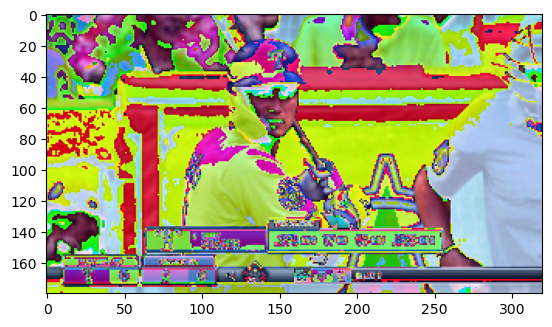

In [10]:
wrong = (predicted_labels != truth)
sorted_prediction = np.flip(np.argsort(prediction.max(axis=1)))

worst_predictions = [i for i in sorted_prediction if wrong[i]]

for index in worst_predictions[0:10]:
    
    print("-----------------",index,"-----------------")
    print(f"Predicted Probability {prediction[index].max().item():.2f}", 'Class' ,predicted_labels[index], lookup_dict[predicted_labels[index]])
    print("True Class",truth[index], lookup_dict[truth[index]])
    _plot_img = imgs[index]
    print(_plot_img.shape)
    plt.imshow(((_plot_img.transpose((1,2,0))+1)/2*255).astype('uint8'))
    plt.show()